In [2]:
# imports
import numpy as np
import pandas as pd

## Dataset Information

### 1. go_track_tracks.csv: 
> a list of trajectories

- id_android - it represents the device used to capture the instance;
- speed - it represents the average speed (Km/H)
- distance - it represent the total distance (Km)
- rating - it is an evaluation parameter. Evaluation the traffic is a way to verify the volunteers perception about the traffic during the travel, in other words,
- if volunteers move to  some place and face traffic jam, maybe they will evaluate 'bad'. 
    
    3 - good,
    
    2 - normal,
    
    1 - bad.

- rating_bus - it is other evaluation parameter. 

    1 - The amount of people inside the bus is little, 

    2 - The bus is not crowded, 
    
    3 - The bus is crowded.

- rating_weather - it is another evaluation parameter. 

    1 - raining.
    
    2 - sunny, 

- car_or_bus 

    1 - car,
    
    2 - bus

- linha - information about the bus that does the pathway

### 2. go_track_trackspoints.csv: 
> localization points of each trajectory

- id: unique key to identify each point
- latitude: latitude from where the point is
- longitude: longitude from where the point is
- track_id: identify the trajectory which the point belong
- hour: datehour when the point was collected (GMT-3)

In [3]:
# load data
tracks_filepath = "../data/go_track_tracks.csv"
tracks_points_filepath = "../data/go_track_trackspoints.csv"

tracks_df = pd.read_csv(tracks_filepath)
tracks_points_df = pd.read_csv(tracks_points_filepath)

tracks_df.shape, tracks_points_df.shape

((163, 10), (18107, 5))

In [4]:
tracks_df.head()

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,0,19.210586,0.138049,2.652,3,0,0,1,NaN
1,2,0,30.848229,0.171485,5.290,3,0,0,1,NaN
2,3,1,13.560101,0.067699,0.918,3,0,0,2,NaN
3,4,1,19.766679,0.389544,7.700,3,0,0,2,NaN
4,8,0,25.807401,0.154801,3.995,2,0,0,1,NaN


In [5]:
# Preprocessing

## Drop columns
tracks_clean = tracks_df.drop(columns=["id_android", "linha"])

# tracks_points_clean = tracks_points_df.drop(columns=["id"])
tracks_points_clean = tracks_points_df

## Drop rows with missing values
tracks_clean = tracks_clean.dropna()

tracks_points_df = tracks_points_clean.dropna()

tracks_clean.shape, tracks_points_df.shape

((163, 8), (18107, 5))

In [6]:
## Merge the two dataframes
# merge on "id" left, "track_id" right 
# rename right time to time_point

tracks_merged = pd.merge(tracks_clean, tracks_points_clean, left_on="id", right_on="track_id")
tracks_merged = tracks_merged.drop(columns=["id_x", "id_y", "track_id"])
tracks_merged = tracks_merged.rename(columns={"time_x": "time", "time_y": "time_point"})

# Drop rows with missing values
tracks_merged = tracks_merged.dropna()

tracks_merged

,speed,time,distance,rating,rating_bus,rating_weather,car_or_bus,latitude,longitude,time_point
0,19.210586,0.138049,2.652,3,0,0,1,-10.939341,-37.062742,2014-09-13 07:24:32
1,19.210586,0.138049,2.652,3,0,0,1,-10.939341,-37.062742,2014-09-13 07:24:37
2,19.210586,0.138049,2.652,3,0,0,1,-10.939324,-37.062765,2014-09-13 07:24:42
3,19.210586,0.138049,2.652,3,0,0,1,-10.939211,-37.062843,2014-09-13 07:24:47
4,19.210586,0.138049,2.652,3,0,0,1,-10.938939,-37.062879,2014-09-13 07:24:53
...,...,...,...,...,...,...,...,...,...,...
18102,1.372998,0.016752,0.023,3,1,2,2,-10.923722,-37.106579,2016-01-19 13:01:01
18103,1.372998,0.016752,0.023,3,1,2,2,-10.923704,-37.106693,2016-01-19 13:01:12
18104,1.372998,0.016752,0.023,3,1,2,2,-10.923715,-37.106688,2016-01-19 13:01:24
18105,1.372998,0.016752,0.023,3,1,2,2,-10.923715,-37.106688,2016-01-19 13:01:36


In [7]:
# timezone: GMT-3
# time is in string format, convert to datetime
tracks_merged["time_slot"] = pd.to_datetime(tracks_merged["time_point"])

# Convert time to slots (morning, adternoon, evening)
def convert_time_to_slot(hour):
    if hour < 12:
        return 1 # "morning"
    elif hour < 18:
        return 2 # "afternoon"
    else:
        return 3 # "evening"

tracks_merged["time_slot"] = tracks_merged["time_slot"].dt.hour.apply(convert_time_to_slot)

# drop time_point, time
tracks_merged = tracks_merged.drop(columns=["time_point", "time"])

tracks_merged["time_slot"].value_counts()

time_slot
1    10059
2     5748
3     2300
Name: count, dtype: int64

In [8]:
# divide in zones

# 1. Get the min and max of lat and long
min_lat = tracks_merged["latitude"].min()
max_lat = tracks_merged["latitude"].max()
min_long = tracks_merged["longitude"].min()
max_long = tracks_merged["longitude"].max()

# 2. Divide the lat and long into 10 zones
lat_zone = np.linspace(min_lat, max_lat, 10)
long_zone = np.linspace(min_long, max_long, 10)

# 3. Create a function to assign the zone
def assign_zone(lat, long, lat_zone, long_zone):
    lat_zone = np.digitize(lat, lat_zone)
    long_zone = np.digitize(long, long_zone)
    return lat_zone, long_zone

# 4. Apply the function to the dataframe
tracks_merged["lat_zone"], tracks_merged["long_zone"] = zip(*tracks_merged.apply(lambda x: assign_zone(x["latitude"], x["longitude"], lat_zone, long_zone), axis=1))

tracks_merged["lat_zone"].value_counts(), tracks_merged["long_zone"].value_counts()

(lat_zone
 9     17988
 1       118
 10        1
 Name: count, dtype: int64,
 long_zone
 9     17987
 1       118
 10        2
 Name: count, dtype: int64)

In [9]:
## Remove Duplicate rows

print(tracks_merged.shape)

tracks_merged = tracks_merged.drop_duplicates()


tracks_merged.shape

(18107, 11)


(14431, 11)

In [10]:
# Save the cleaned data
merged_filepath = "../data/go_tracks_merged.csv"

tracks_merged.to_csv(merged_filepath, index=False)

tracks = pd.read_csv(merged_filepath)

print(tracks.shape)

tracks.head()

(14431, 11)


,speed,distance,rating,rating_bus,rating_weather,car_or_bus,latitude,longitude,time_slot,lat_zone,long_zone
0,19.210586,2.652,3,0,0,1,-10.939341,-37.062742,1,9,9
1,19.210586,2.652,3,0,0,1,-10.939341,-37.062742,1,9,9
2,19.210586,2.652,3,0,0,1,-10.939324,-37.062765,1,9,9
3,19.210586,2.652,3,0,0,1,-10.939211,-37.062843,1,9,9
4,19.210586,2.652,3,0,0,1,-10.938939,-37.062879,1,9,9


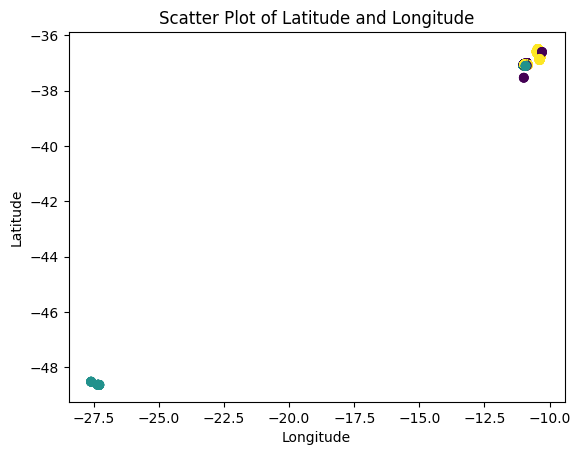

In [11]:
# plot points on a map

import matplotlib.pyplot as plt

# Scatter plot of latitude and longitude
plt.scatter(tracks["latitude"], tracks["longitude"], c=tracks["time_slot"], cmap="viridis")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude")
plt.show()

In [20]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

tracks_scaled = tracks.copy()

tracks_scaled[["speed", "distance"]] = scaler.fit_transform(tracks[["speed", "distance"]])

tracks_scaled

,speed,distance,rating,rating_bus,rating_weather,car_or_bus,latitude,longitude,time_slot,lat_zone,long_zone,cluster_kn,cluster_agg
0,0.199600,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,2,1
1,0.199600,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,2,1
2,0.199600,0.047535,3,0,0,1,-10.939324,-37.062765,1,9,9,2,1
3,0.199600,0.047535,3,0,0,1,-10.939211,-37.062843,1,9,9,2,1
4,0.199600,0.047535,3,0,0,1,-10.938939,-37.062879,1,9,9,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,0.014171,0.000394,3,1,2,2,-10.923722,-37.106579,2,9,9,4,0
14427,0.014171,0.000394,3,1,2,2,-10.923704,-37.106693,2,9,9,4,0
14428,0.014171,0.000394,3,1,2,2,-10.923715,-37.106688,2,9,9,4,0
14429,0.014171,0.000394,3,1,2,2,-10.923715,-37.106688,2,9,9,4,0


In [19]:
# take a sample of the data
tracks_sample = tracks_scaled.sample(1000)
# tracks_sample = tracks_scaled

### Chameleon algorithm

The Chameleon algorithm is a hierarchical clustering technique that uses dynamic modelling to find clusters based on two main criteria: interconnectivity and closeness. Unlike other clustering algorithm that predetermine the number of clusters or that rely on global properties like the cluster centroid or cluster density, Chameleon adapts to the local data characteristics.


### Algorithm Steps:

#### Phase 1: Graph Partitioning

Use a graph partitioning algorithm to partition the data into a large number of subclusters. This could involve creating a k-nearest neighbour graph and then partitioning.

In [21]:
# Use a graph partitioning algorithm to partition the data into a large number 
# of subclusters. This could involve creating a k-nearest neighbour graph and then 
# partitioning.

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

tracks_subset = tracks_scaled.drop(columns=["lat_zone", "long_zone"])

# kneighbors graph
A = kneighbors_graph(tracks_subset, n_neighbors=10, mode='connectivity', include_self=True)

# spectral clustering
spectral = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=0)

# fit the model
spectral.fit(A)

# add the cluster labels to the dataframe
tracks_scaled["cluster_kn"] = spectral.labels_

# print the cluster counts
print(tracks_scaled["cluster_kn"].value_counts())

tracks_scaled.head()

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


cluster_kn
1    6894
4    4349
0    2945
3     232
2      11
Name: count, dtype: int64


,speed,distance,rating,rating_bus,rating_weather,car_or_bus,latitude,longitude,time_slot,lat_zone,long_zone,cluster_kn,cluster_agg
0,0.1996,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,1,1
1,0.1996,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,1,1
2,0.1996,0.047535,3,0,0,1,-10.939324,-37.062765,1,9,9,1,1
3,0.1996,0.047535,3,0,0,1,-10.939211,-37.062843,1,9,9,1,1
4,0.1996,0.047535,3,0,0,1,-10.938939,-37.062879,1,9,9,1,1


#### Phase 2: Agglomerative Hierarchical Clustering

Use an agglomerative hierarchical clustering approach to iteratively merge these subclusters based on dynamic modelling. The merging process takes into account the inter-connectivity and closeness of the subclusters, which are calculated using relative closeness and relative interconnectivity measures.

In [22]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

tracks_subset = tracks_scaled.drop(columns=["lat_zone", "long_zone", "cluster_kn"])

# agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=5)

# fit the model
agglomerative.fit(tracks_subset)

# add the cluster labels to the dataframe
tracks_scaled["cluster_agg"] = agglomerative.labels_

# print the cluster counts
print(tracks_scaled["cluster_agg"].value_counts())

tracks_scaled.head()

cluster_agg
1    6697
2    3214
4    2461
0    1996
3      63
Name: count, dtype: int64


,speed,distance,rating,rating_bus,rating_weather,car_or_bus,latitude,longitude,time_slot,lat_zone,long_zone,cluster_kn,cluster_agg
0,0.1996,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,1,1
1,0.1996,0.047535,3,0,0,1,-10.939341,-37.062742,1,9,9,1,1
2,0.1996,0.047535,3,0,0,1,-10.939324,-37.062765,1,9,9,1,1
3,0.1996,0.047535,3,0,0,1,-10.939211,-37.062843,1,9,9,1,1
4,0.1996,0.047535,3,0,0,1,-10.938939,-37.062879,1,9,9,1,1


In [23]:
## add the cluster labels to the dataframe
tracks["cluster_kn"] = tracks_scaled["cluster_kn"]
tracks["cluster_agg"] = tracks_scaled["cluster_agg"]

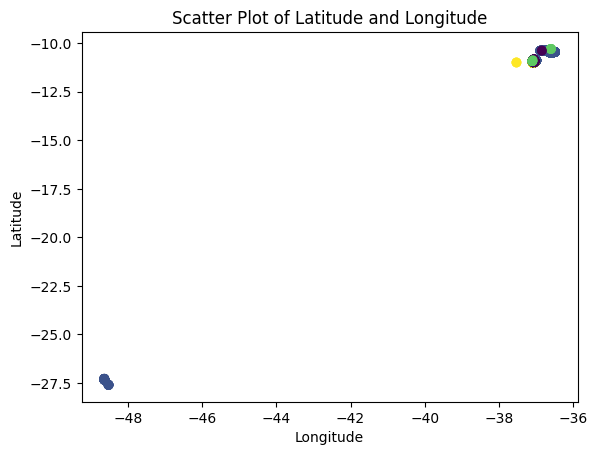

In [24]:
import matplotlib.pyplot as plt

# Scatter plot of latitude and longitude
plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_kn"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude")
plt.show()


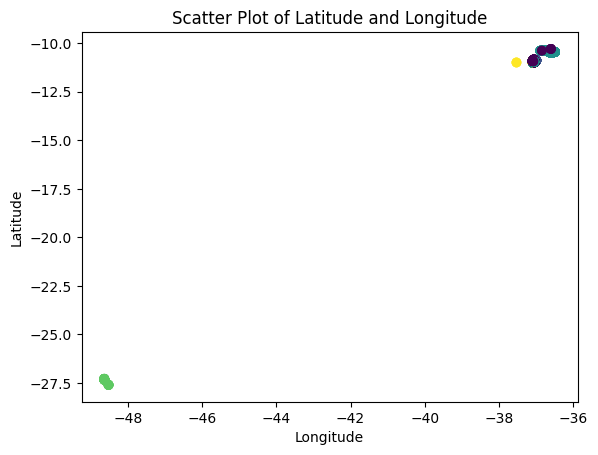

In [25]:
import matplotlib.pyplot as plt

# Scatter plot of latitude and longitude
plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_agg"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude")
plt.show()


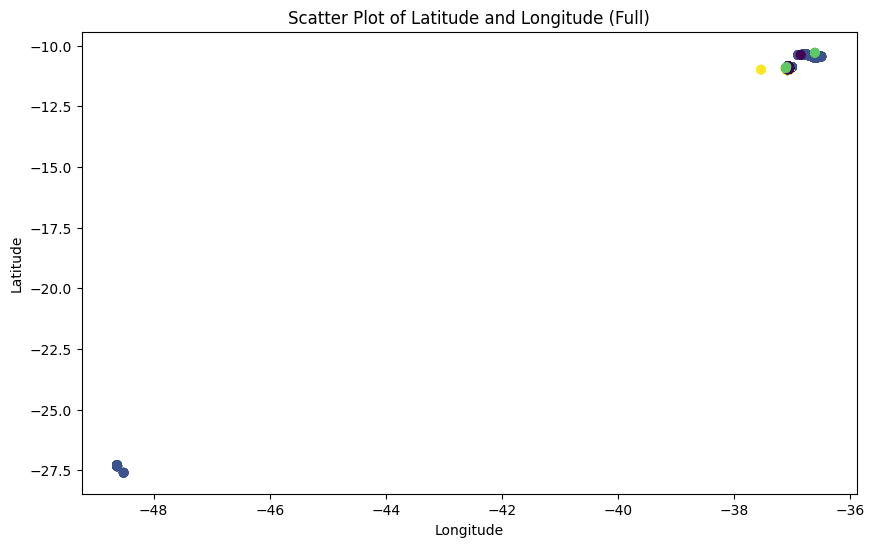

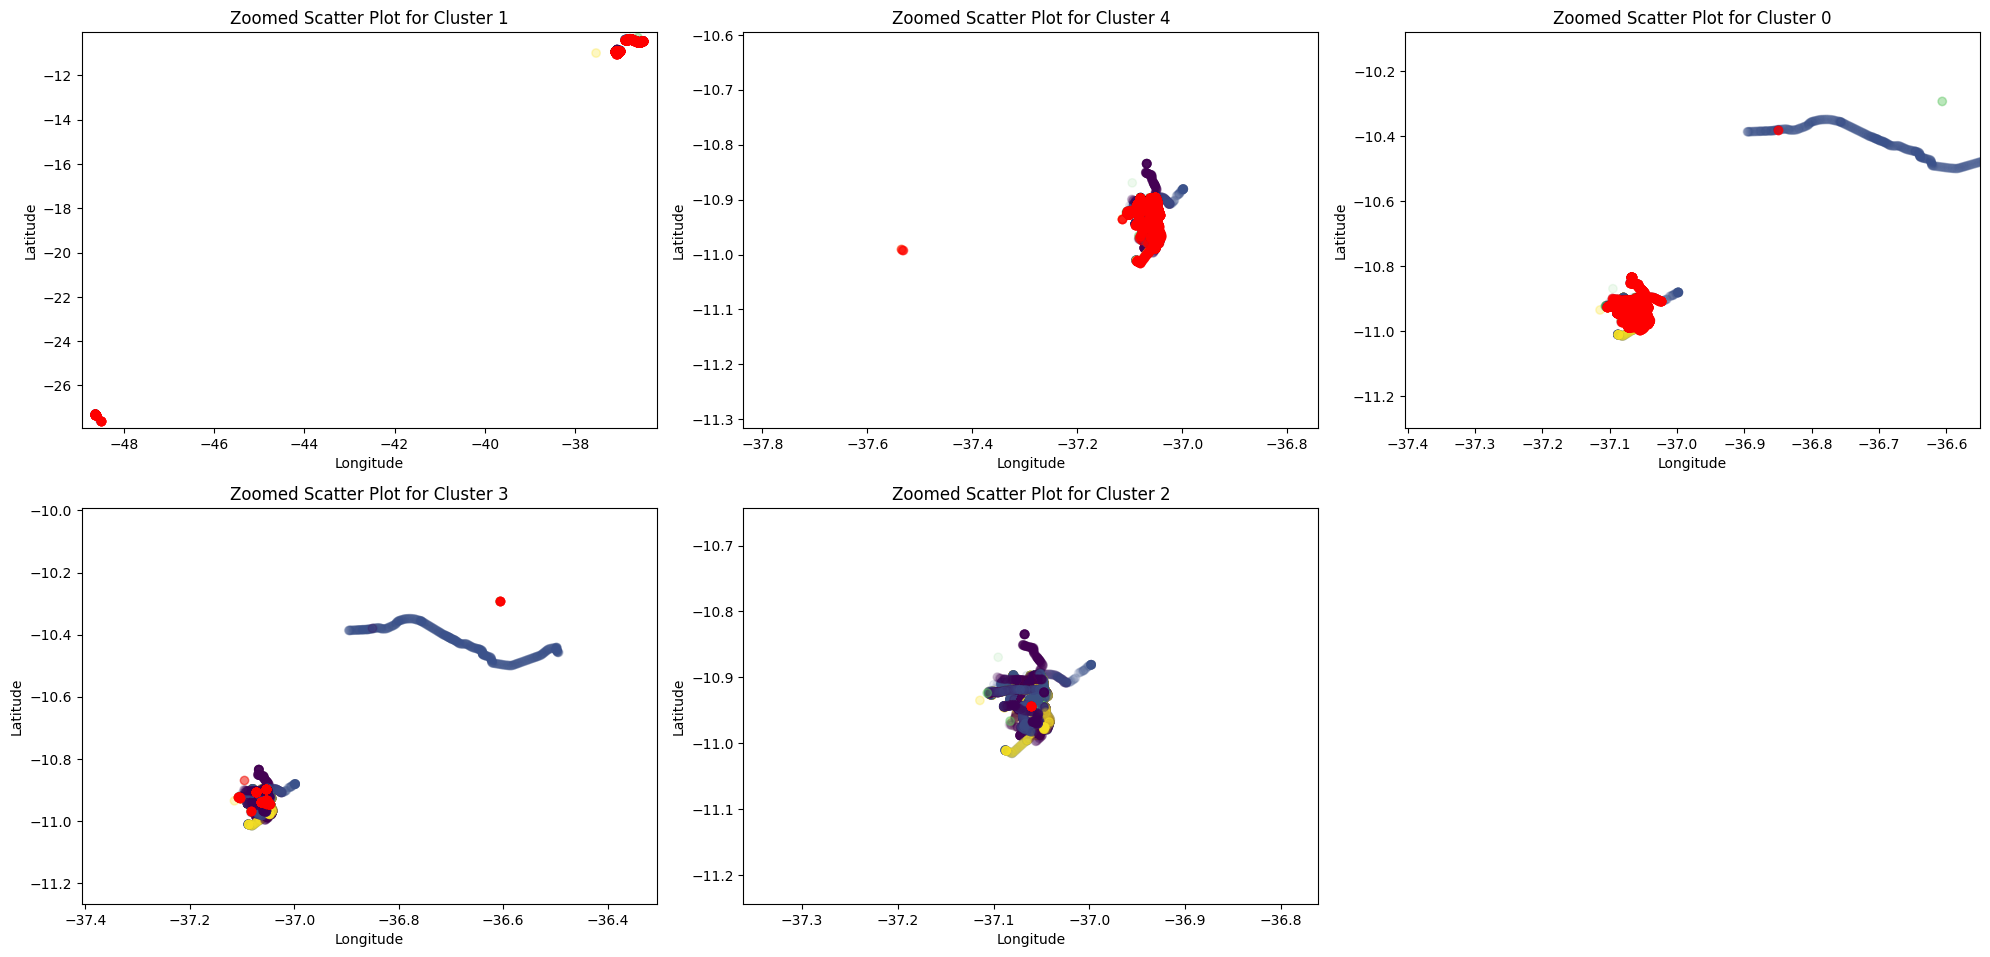

In [46]:
import matplotlib.pyplot as plt

# Sample data
# tracks is assumed to be your DataFrame containing latitude, longitude, and cluster_agg columns

# Full scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_kn"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude (Full)")

plt.show()

plt.figure(figsize=(20, 14))
# Iterate over each cluster
unique_clusters = tracks["cluster_kn"].unique()
for i, cluster in enumerate(unique_clusters, 1):
    # Create subplot
    plt.subplot(3, 3, i)
    plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_kn"], alpha=0.1)  # Reduce opacity with alpha parameter
    plt.scatter(tracks["longitude"][tracks["cluster_kn"] == cluster], tracks["latitude"][tracks["cluster_kn"] == cluster], c='r', alpha=0.5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Zoomed Scatter Plot for Cluster {cluster}")
    
    # Set x and y limits to zoom on the current cluster
    plt.xlim(tracks["longitude"][tracks["cluster_kn"] == cluster].min() - 0.3, tracks["longitude"][tracks["cluster_kn"] == cluster].max() + 0.3)
    plt.ylim(tracks["latitude"][tracks["cluster_kn"] == cluster].min() - 0.3, tracks["latitude"][tracks["cluster_kn"] == cluster].max() + 0.3)

plt.tight_layout()
plt.show()

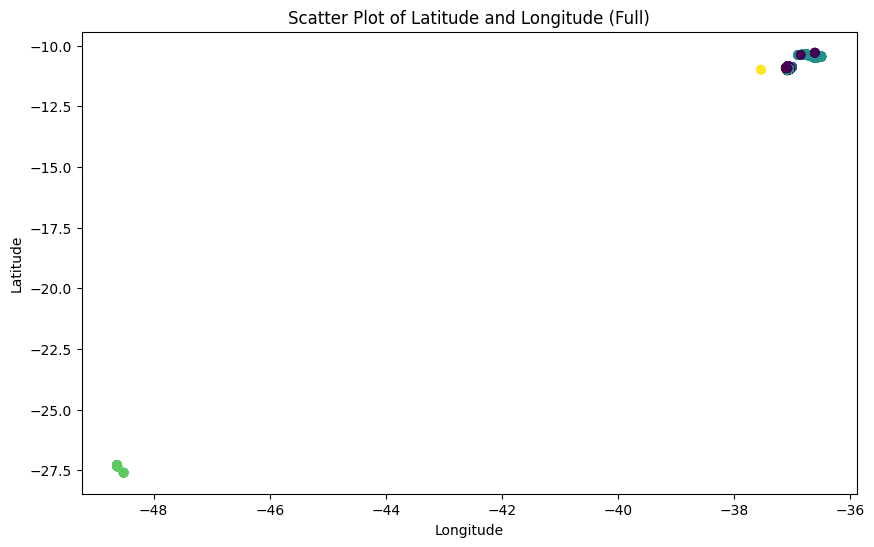

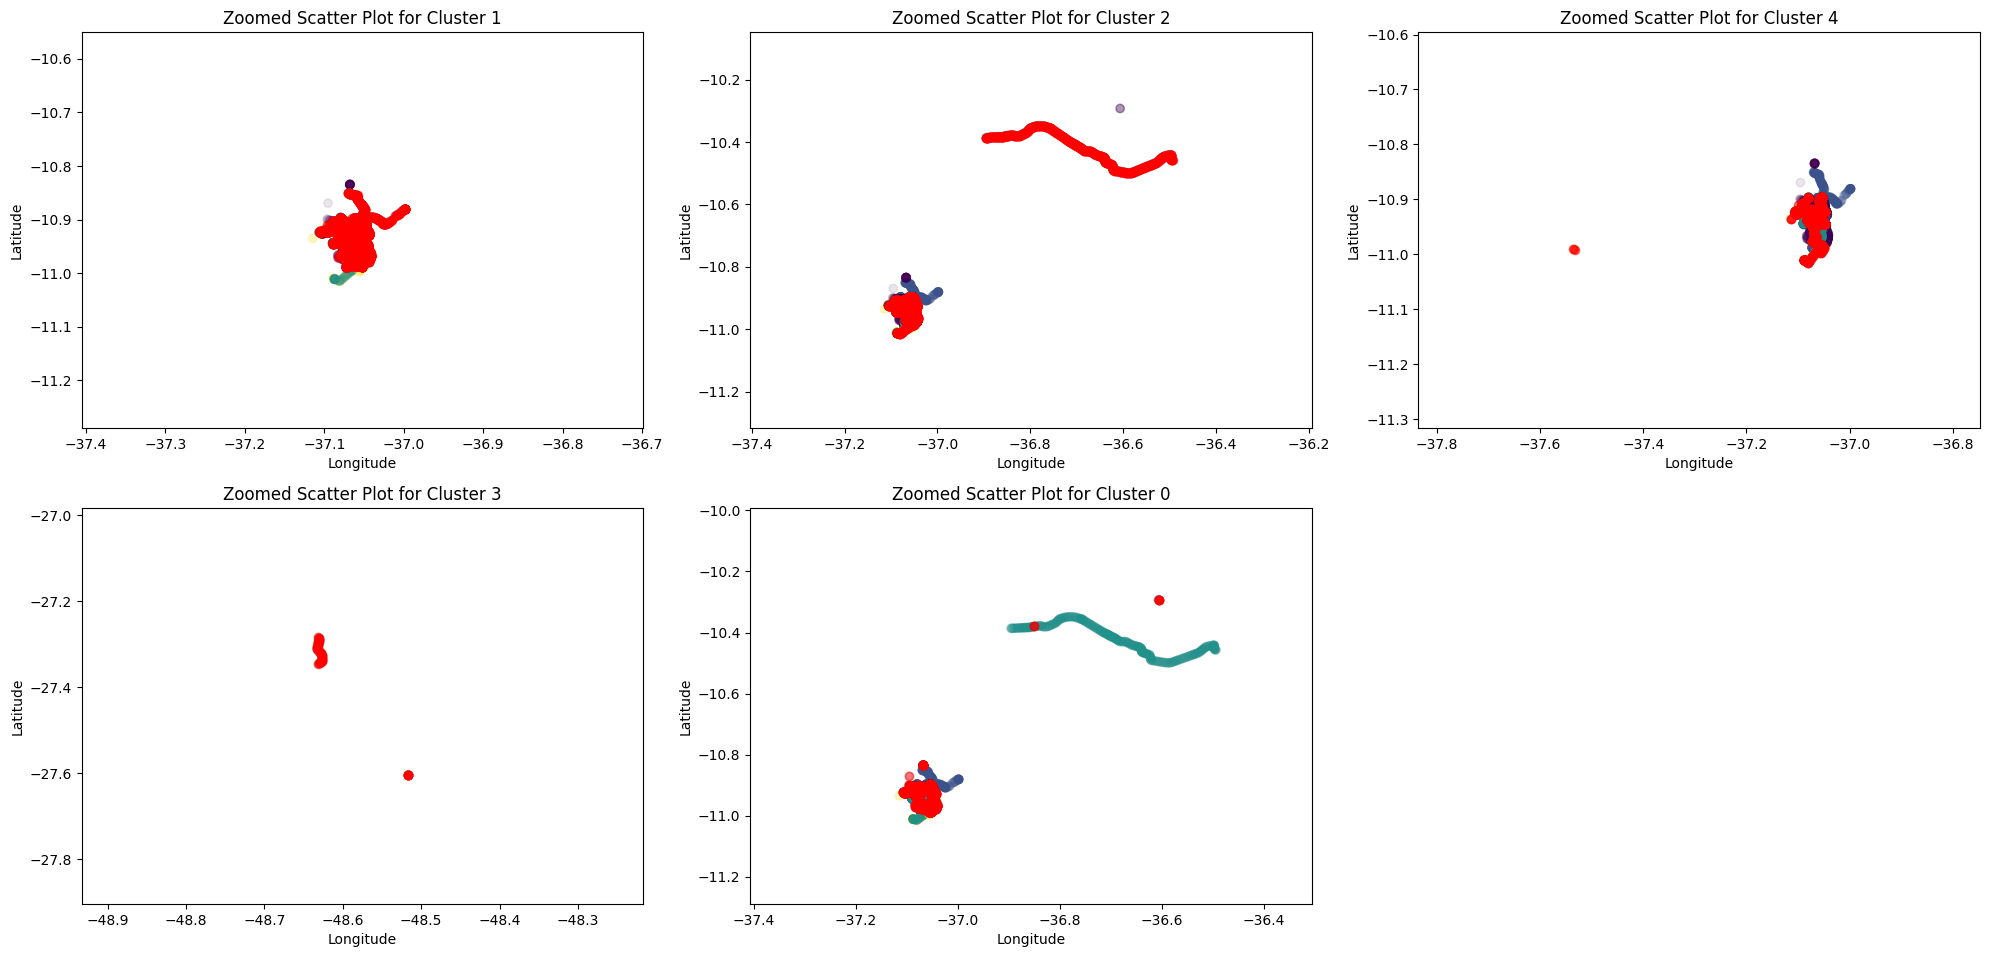

In [48]:
import matplotlib.pyplot as plt

# Sample data
# tracks is assumed to be your DataFrame containing latitude, longitude, and cluster_agg columns

# Full scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_agg"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of Latitude and Longitude (Full)")

plt.show()

plt.figure(figsize=(20, 14))

# Iterate over each cluster
unique_clusters = tracks["cluster_agg"].unique()
for i, cluster in enumerate(unique_clusters, 1):
    # Create subplot
    plt.subplot(3, 3, i)
    plt.scatter(tracks["longitude"], tracks["latitude"], c=tracks["cluster_agg"], alpha=0.1)  # Reduce opacity with alpha parameter
    plt.scatter(tracks["longitude"][tracks["cluster_agg"] == cluster], tracks["latitude"][tracks["cluster_agg"] == cluster], c='r', alpha=0.5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Zoomed Scatter Plot for Cluster {cluster}")
    # Set x and y limits to zoom on the current cluster
    plt.xlim(tracks["longitude"][tracks["cluster_agg"] == cluster].min() - 0.3, tracks["longitude"][tracks["cluster_agg"] == cluster].max() + 0.3)
    plt.ylim(tracks["latitude"][tracks["cluster_agg"] == cluster].min() - 0.3, tracks["latitude"][tracks["cluster_agg"] == cluster].max() + 0.3)

plt.tight_layout()
plt.show()